<a href="https://colab.research.google.com/github/kennardmah/classification-cyberbullying/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
! pip install torchmetrics

In [164]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import math

from tabulate import tabulate
import tqdm
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

### Prepare Data

In [165]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [166]:
path = '/content/drive/MyDrive/ADL/PAPER/cyberbullying_tweets.csv.zip'

In [167]:
import zipfile

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()
df = pd.read_csv('cyberbullying_tweets.csv')
print(df.head())

                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


In [168]:
df.info()
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [169]:
df.duplicated().sum()

36

In [170]:
df = df.drop_duplicates()

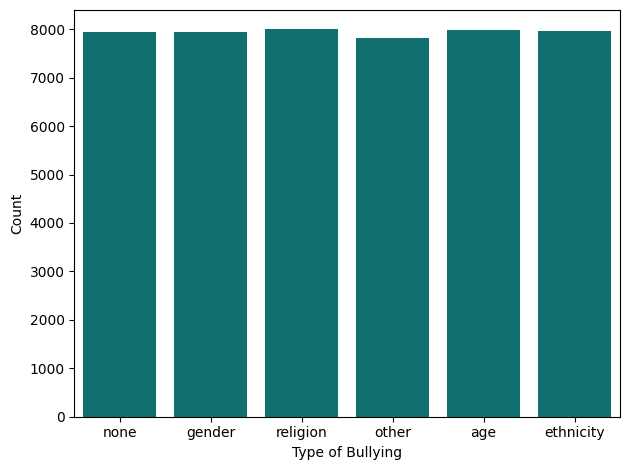

In [171]:
# plot distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.color_palette("cubehelix", as_cmap=True)

# change other_cyberbullying to other and not_cyberbullying to none
df['sentiment'] = df['sentiment'].replace(['other_cyberbullying'], 'other')
df['sentiment'] = df['sentiment'].replace(['not_cyberbullying'], 'none')
sns.countplot(x='sentiment', data=df, color='#008080')
# fix labeling
# plt.title('Sentiment Distribution')
plt.xlabel('Type of Bullying')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [172]:
!pip install emoji
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [173]:
import re
import string
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

def remove_emojis(text):
    text = emoji.demojize(text)
    text = text.replace(':', ' ')
    text = ' '.join(text.split())
    return text

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])

def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = nltk.word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in word_tokens])

def preprocess_text(text):
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = lemmatize_words(text)
    text = stem_words(text)
    return text

df['text'] = df['text'].apply(preprocess_text)

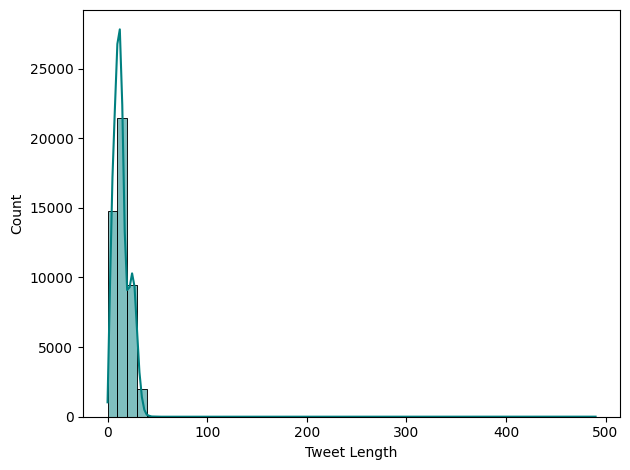

<ipython-input-174-9ef9c9a3e4eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('tweet_length', axis=1, inplace=True)


In [174]:
# plot tweets by length
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['tweet_length'], bins=50, kde=True, color='#008080')
# plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# filter out tweets over 50 words
df = df[df['tweet_length'] <= 30]

df.drop('tweet_length', axis=1, inplace=True)


### Tokenization

In [175]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

token_ids = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    return tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

for text in df.text:
    encoding_dict = preprocessing(text, tokenizer)
    token_ids.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [176]:
labels = df['sentiment'].map({'none': 0, 'gender': 1, 'religion': 2, 'ethnicity': 3, 'age': 4, 'other': 5}).values
labels = torch.tensor(labels)

In [177]:
val_ratio = 0.2
batch_size = 16

train_idx, val_idx = train_test_split(
    np.arange(len(df)),
    test_size=val_ratio,
    shuffle=True,
    stratify=labels
)

train_set = TensorDataset(token_ids[train_idx],
                          attention_masks[train_idx],
                          labels[train_idx])

val_set = TensorDataset(token_ids[val_idx],
                        attention_masks[val_idx],
                        labels[val_idx])

train_loader = DataLoader(
    train_set,
    sampler=RandomSampler(train_set),
    batch_size=batch_size
)

val_loader = DataLoader(
    val_set,
    sampler=SequentialSampler(val_set),
    batch_size=batch_size
)

In [178]:
print('{:>5,} training samples'.format(train_set.__len__()))
print('{:>5,} validation samples'.format(val_set.__len__()))

36,960 training samples
9,241 validation samples


In [179]:
fine_tune = True
epochs = 3
learning_rate = [2e-5, 3e-5, 5e-5][1]

In [180]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False
)

total_parameters = 0

for name, param in model.named_parameters():
    param.requires_grad = False
    if 'classifier' in name:
        param.requires_grad = True
        total_parameters += param.numel()

print(f'Total parameters (no fine tune): {total_parameters}')

if fine_tune:
    for name, param in model.named_parameters():
        param.requires_grad = True
        total_parameters += param.numel()

print(f'Total parameters (fine tune): {total_parameters}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (no fine tune): 4614
Total parameters (fine tune): 109491468


In [181]:
import platform

# Pick the system you have and select GPU if you can
if platform.system() == 'Darwin':
    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
elif platform.system() == 'Linux':
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
else:
    device = torch.device('cpu')
print(device)

cuda


In [182]:
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train the model

In [183]:
_ = model.to(device)

In [ ]:
all_preds = {}
all_labels = {}
all_logits = {}

for _ in tqdm.tqdm(range(1)):
    model.train()
    training_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_output.loss.backward()

        optimizer.step()

        training_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    model.eval()

    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []
    pred_list = []
    label_list = []
    logit_list = []


    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            eval_output = model(b_input_ids, attention_mask=b_input_mask)

        labels = b_labels.cpu()
        logits = eval_output.logits.cpu() # Store logits for AUROC calculation
        preds = torch.argmax(logits, axis=1).flatten()

        pred_list.extend(preds) # Use extend to accumulate predictions
        label_list.extend(labels) # Use extend to accumulate labels
        logit_list.extend(logits) # Use extend to accumulate logits

        val_accuracy.append(Accuracy(task='multiclass', num_classes=6)(preds, labels))
        val_precision.append(Precision(task='multiclass', num_classes=6)(preds, labels))
        val_recall.append(Recall(task='multiclass', num_classes=6)(preds, labels))
        val_auroc.append(AUROC(task='multiclass', num_classes=6)(logits, labels)) # Calculate AUROC here using logits

    all_preds[f'epoch_{_}'] = pred_list
    all_labels[f'epoch_{_}'] = label_list
    all_logits[f'epoch_{_}'] = logit_list

    # Calculate AUROC after accumulating all predictions and labels for the epoch
    val_auroc = AUROC(task='multiclass', num_classes=6)(torch.stack(logit_list), torch.stack(label_list))

    print('\n\t - Train loss: {:.4f}'.format(training_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(torch.mean(torch.tensor(val_accuracy))))
    print('\t - Validation Precision: {:.4f}'.format(torch.mean(torch.tensor(val_precision))))
    print('\t - Validation Recall: {:.4f}'.format(torch.mean(torch.tensor(val_recall))))
    print('\t - Validation AUROC: {:.4f}'.format(val_auroc)) # Print AUROC for the epoch

  0%|          | 0/1 [00:00<?, ?it/s]

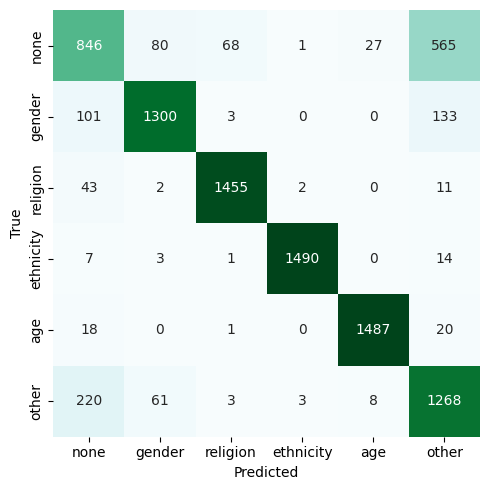

In [185]:
epoch_key = 'epoch_1'  # Change this to access a different epoch's results
preds = all_preds[epoch_key]
labels = all_labels[epoch_key]

# Create the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', cbar=False,
            xticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'],
            yticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

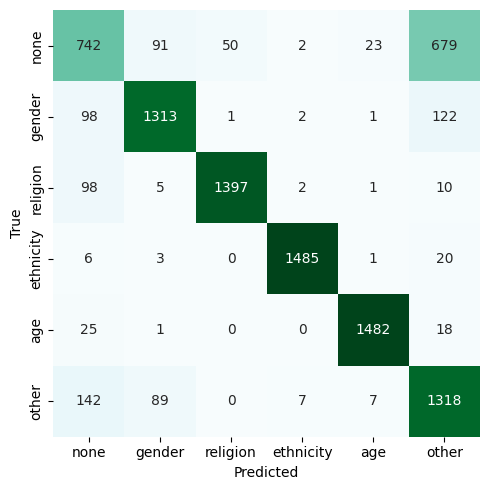

In [186]:
epoch_key = 'epoch_0'  # Change this to access a different epoch's results
preds = all_preds[epoch_key]
labels = all_labels[epoch_key]

# Create the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', cbar=False,
            xticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'],
            yticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [188]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(labels, preds, target_names=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])

NameError: name 'classification_report' is not defined

In [ ]:
# prompt: generate the same thing but this time using RoBERTa

from transformers import RobertaTokenizer, RobertaForSequenceClassification
# ... (rest of your imports and data preprocessing code)

# ### Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# ... (rest of your tokenization code, using the RobertaTokenizer)

# ### Model Initialization
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False
)

# ... (rest of your model training and evaluation code)
# Make sure to replace BertForSequenceClassification with RobertaForSequenceClassification
# and adjust hyperparameters if necessary.